In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [ ]:
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.runnables import RunnablePassthrough
# from langchain_community.document_loaders import TextLoader, DirectoryLoader
# from langchain_community.vectorstores import Chroma
# from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
# docs=loader.load()
# text_splitter=RecursiveCharacterTextSplitter(
#     chunk_size=100,
#     chunk_overlap=50
# )
# new_docs = text_splitter.split_documents(documents=docs)
# doc_strings = [doc.page_content for doc in new_docs]

In [ ]:
# db = Chroma.from_documents(new_docs, embeddings)

# retriever = db.as_retriever(search_kwargs={"k": 3})

In [ ]:
# query = "what is meta llama3?"
# docs = retriever.get_relevant_documents(query)
# print(docs[0].metadata)
# print(docs[0].page_content)

# for doc in docs:
#     print(doc)

{'source': '..\\data\\llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '..\\data\\llama3.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': '..\\data\\llama3.txt'}
page_content='Llama 2, Meta AI started releasing instruction fine-tuned versions alongside foundation models.[7]' metadata={'source': '..\\data\\llama3.txt'}


In [33]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.schema.document import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [4]:
def load_documents():
    document_loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
    return document_loader.load()

def split_documents(documents: list[Document]):
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

def add_to_chroma(chunks: list[Document]):
    db=Chroma.from_documents(documents=chunks,embedding=embeddings,persist_directory="Chroma")
    return db

In [6]:
if __name__=="__main__":
    documents=load_documents()
    chunks=split_documents(documents=documents)
    db=add_to_chroma(chunks=chunks)

In [9]:
retriever = db.as_retriever()

In [31]:
query = "who invented llama3?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)


{'source': '..\\data\\llama3.txt'}
Llama models have been compared favorably against other large language models. Meta AI reported the original 13B parameter model's performance on most NLP benchmarks exceeded that of the much larger GPT-3 (with 175B parameters) and that the largest model was competitive with state of the art models such as PaLM and Chinchilla.[2]. Meta AI's testing shows that Llama 3 70B beats Gemini, and Claude in most benchmarks.[9][10] Wired describes the 8B parameter version of Llama 3 as being "surprisingly capable" given it's size.[11]


In [32]:
def function_1(AgentState):
    message=AgentState["messages"]
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState

In [34]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [35]:
# Define a Langchain graph
from langgraph.graph import Graph
workflow = Graph()
workflow.add_node("LLM", function_1)
workflow.add_node("RAGtool", function_2)
workflow.add_edge('LLM', 'RAGtool')
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAGtool")
app = workflow.compile()

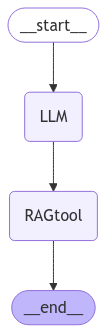

In [36]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [40]:
inputs = {"messages": ["which company introduced llama3 model?"]}

In [41]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'LLM':
---
{'messages': ['which company introduced llama3 model?', 'Meta']}

---

Output from node 'RAGtool':
---
Meta AI

---

